In [1]:
import os
import numpy
from scipy.interpolate import interp1d

root = 'logs/'
algos = ['a2c', 'acktr', 'ppo']
games = ['beamrider', 'breakout', 'qbert']
lrs = ['lrexp_div10', 'lrhalf', 'baseline', 'lrdouble', 'lrexp_mul10']
lrLabels = {
    'a2c': {
        'lrexp_div10': '7e-5',
        'lrexp_mul10': '7e-3',
        'lrhalf': '3.5e-4',
        'lrdouble': '1.4e-3',
        'baseline': '7e-4'
    },
    'ppo': {
        'lrexp_div10': '2.5e-5',
        'lrexp_mul10': '2.5e-3',
        'lrhalf': '1.25e-4',
        'lrdouble': '5e-4',
        'baseline': '2.5e-4'
    },
    'acktr': {
        'lrexp_div10': '7e-5',
        'lrexp_mul10': '7e-3',
        'lrhalf': '3.5e-4',
        'lrdouble': '1.4e-3',
        'baseline': '7e-4'
    }
}
numTrials = 5

def getLogFileNames(trialName):
    folderPath = root + trialName
    logFileNames = [fileName for fileName in os.listdir(folderPath) if 'monitor' in fileName]
    return folderPath, logFileNames
    
def getTrialStats(trialName):
    folderPath, logFileNames = getLogFileNames(trialName)
    #print(folderPath)
    
    logs = []
    for fileName in logFileNames:
        filePath = folderPath + '/' + fileName
        log_lines = []
        with open(filePath, 'r') as log_file:
            log_lines = log_file.readlines()
        logs.append(log_lines[2:])

    numProcesses = len(logs)
    timeSteps = []
    rewards = []
    for log in logs:
        curTimeStep = 0
        for line in log:
            lineParts = line.split(',')
            episodeReward = float(lineParts[0])
            episodeSteps = int(lineParts[1])
            episodeTime = float(lineParts[2])
            curTimeStep += episodeSteps * numProcesses
            timeSteps.append(curTimeStep)
            rewards.append(episodeReward)

    return timeSteps, rewards

def standardize_times(times):
    startTime = times[0]
    endTime = times[-1]
    #numTimes = len(times)
    numTimes = 3000
    return numpy.linspace(startTime, endTime, numTimes)

def standardize_rewards(standardTimes, times, rewards):
    f = interp1d(times, rewards, kind='nearest')
    return f(standardTimes)

In [2]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 24, 6 #width, height

def running_mean(x, N):
    cumsum = numpy.cumsum(numpy.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

fig, axs = plt.subplots(1, 3)  
for i, algo in enumerate(algos):
    ax = axs[i]
    ax.set_title(algo, fontsize=18)
    for j, lr in enumerate(lrs):
        standardRewardsList = []
        for trialNum in range(1, numTrials + 1):
            trialNumStr = str(trialNum)
            if lr == 'baseline':
                lrStr = ''
            else:
                lrStr = '_' + lr
            trialName = algo + '_' + game + lrStr + '_' + trialNumStr
            times, rewards = getTrialStats(trialName)
            times, rewards = zip(*sorted(zip(times, rewards)))
            lastTime = numpy.argmax(numpy.array(times) > 3e6)
            times = times[:lastTime]
            rewards = rewards[:lastTime]
            standardTimes = standardize_times(times)
            standardRewards = standardize_rewards(standardTimes, times, rewards)
            standardRewardsList.append(standardRewards)
        standardRewardsMat = numpy.array(standardRewardsList)
        rewardsMean = standardRewardsMat.mean(axis=0)
        rewardsError = standardRewardsMat.std(axis=0)
        smoothRewards = running_mean(rewardsMean, 50)
        smoothError = running_mean(rewardsError, 50)
        ax.plot(standardTimes[:-49] / 1e6, smoothRewards, label=lrLabels[algo][lr])
        #if j == 0:
        #ax.fill_between(standardTimes[:-49] / 1e6, smoothRewards - smoothError, smoothRewards + smoothError, alpha=0.2)
    ax.legend(loc='upper left', fontsize=18)
    ax.set_xlabel('Timesteps (millions)', fontsize=18)
    if i == 0:
        ax.set_ylabel('Reward', fontsize=18) 
    ax.tick_params(axis='both', which='major', labelsize=14)
    
#plt.show()
plt.savefig('learning_rate.png', bbox_inches='tight')
plt.show()

NameError: name 'game' is not defined

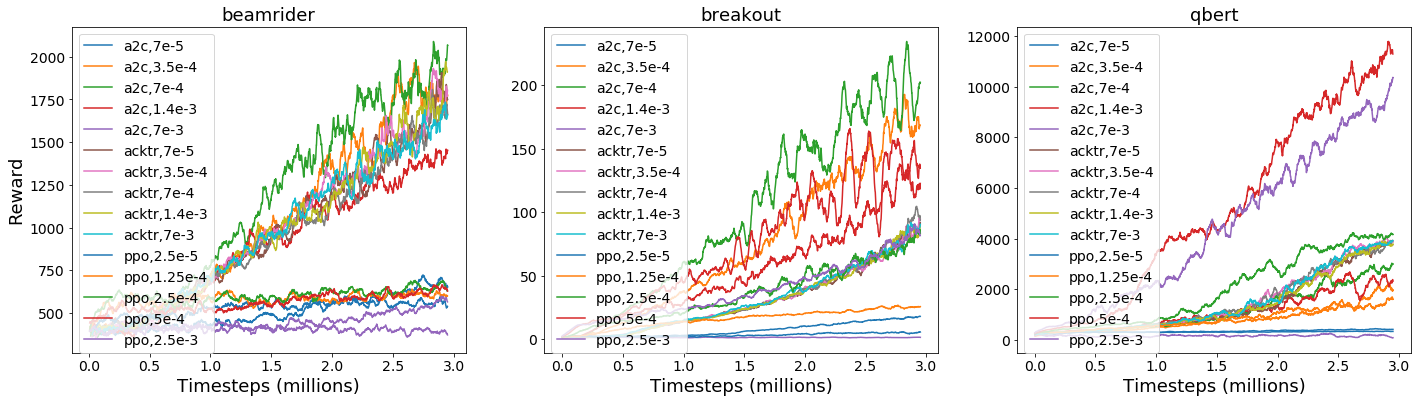

In [8]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 24, 6 #width, height

def running_mean(x, N):
    cumsum = numpy.cumsum(numpy.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

fig, axs = plt.subplots(1, 3)  
for i, game in enumerate(games):
    ax = axs[i]
    ax.set_title(game, fontsize=18)
    for j, algo in enumerate(algos):
        for k, lr in enumerate(lrs):
            standardRewardsList = []
            for trialNum in range(1, numTrials + 1):
                trialNumStr = str(trialNum)
                if lr == 'baseline':
                    lrStr = ''
                else:
                    lrStr = '_' + lr
                trialName = algo + '_' + game + lrStr + '_' + trialNumStr
                times, rewards = getTrialStats(trialName)
                times, rewards = zip(*sorted(zip(times, rewards)))
                lastTime = numpy.argmax(numpy.array(times) > 3e6)
                #print(lastTime)
                times = times[:lastTime]
                rewards = rewards[:lastTime]
                #print(trialName)
                standardTimes = standardize_times(times)
                standardRewards = standardize_rewards(standardTimes, times, rewards)
                standardRewardsList.append(standardRewards)
            standardRewardsMat = numpy.array(standardRewardsList)
            rewardsMean = standardRewardsMat.mean(axis=0)
            rewardsError = standardRewardsMat.std(axis=0)
            smoothRewards = running_mean(rewardsMean, 50)
            smoothError = running_mean(rewardsError, 50)
            ax.plot(standardTimes[:-49] / 1e6, smoothRewards, label=algo + ',' + lrLabels[algo][lr])
            #if j == 0:
            #ax.fill_between(standardTimes[:-49] / 1e6, smoothRewards - smoothError, smoothRewards + smoothError, alpha=0.2)
    ax.legend(loc='upper left', fontsize=14)
    ax.set_xlabel('Timesteps (millions)', fontsize=18)
    if i == 0:
        ax.set_ylabel('Reward', fontsize=18) 
    ax.tick_params(axis='both', which='major', labelsize=14)
    
#plt.show()
plt.savefig('full_learning_rate.png', bbox_inches='tight')
plt.show()

In [11]:
print('\\begin{table}[thb]')
print('\centering')
print('{\small')
print('    \\begin{tabular}{|c|c|c|c|}')
print('    \\hline')
print('    & \multicolumn{3}{c|}{Algorithm} \\\\\cline{2-4}')
print('    Game  & div10 & half & baseline & double & mul10 \\\\\hline')

def running_mean(x, N):
    cumsum = numpy.cumsum(numpy.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

algo = 'acktr'
for i, game in enumerate(games):
    rowStr = '    ' + str(game)
    for k, lr in enumerate(lrs):
        lastRewards = []
        for trialNum in range(1, numTrials + 1):
            trialNumStr = str(trialNum)
            if lr == 'baseline':
                lrStr = ''
            else:
                lrStr = '_' + lr
            trialName = algo + '_' + game + lrStr + '_' + trialNumStr
            times, rewards = getTrialStats(trialName)
            times, rewards = zip(*sorted(zip(times, rewards)))
            cutoffIndex = next(x[0] for x in enumerate(times) if x[1] > 3e6)
            rewards = rewards[:cutoffIndex]
            lastRewards.extend(rewards[-100:])
        lastRewardsArr = numpy.array(lastRewards)
        mean = lastRewardsArr.mean(axis=0)
        std = lastRewardsArr.std(axis=0)
        rowStr += ' & ' + str(int(mean)) + ' $\pm$ ' + str(int(std))
    rowStr += ' \\\ \\hline'
    print(rowStr)

print('    \end{tabular}')
print('    }')
print('    \caption{Mean reward, with standard deviation, for last 100 episodes, taken from 5 trials for each algorithm and seed (including baseline, which is seed 1) trained and evaluated on BeamRider, after 3 million time steps.}')
print('    \label{tbl:seed_comparison}')
print('\end{table}')

\begin{table}[thb]
\centering
{\small
    \begin{tabular}{|c|c|c|c|}
    \hline
    & \multicolumn{3}{c|}{Algorithm} \\\cline{2-4}
    Game  & div10 & half & baseline & double & mul10 \\\hline
    beamrider & 1724 $\pm$ 805 & 1810 $\pm$ 875 & 1647 $\pm$ 760 & 1749 $\pm$ 767 & 1612 $\pm$ 696 \\ \hline
    breakout & 86 $\pm$ 54 & 85 $\pm$ 48 & 94 $\pm$ 56 & 82 $\pm$ 47 & 89 $\pm$ 52 \\ \hline
    qbert & 3876 $\pm$ 1169 & 3964 $\pm$ 1035 & 3817 $\pm$ 1153 & 3804 $\pm$ 1202 & 3911 $\pm$ 929 \\ \hline
    \end{tabular}
    }
    \caption{Mean reward, with standard deviation, for last 100 episodes, taken from 5 trials for each algorithm and seed (including baseline, which is seed 1) trained and evaluated on BeamRider, after 3 million time steps.}
    \label{tbl:seed_comparison}
\end{table}


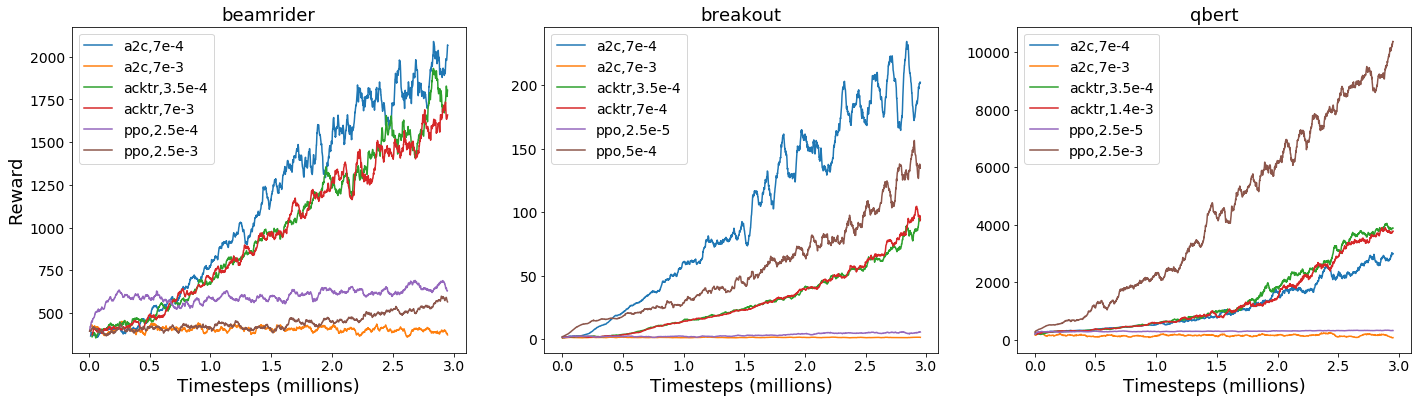

In [17]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 24, 6 #width, height

def running_mean(x, N):
    cumsum = numpy.cumsum(numpy.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


whitelist = ['ppo_beamrider_lrexp_mul10', 'ppo_beamrider', 'a2c_beamrider_lrexp_mul10', 'a2c_beamrider', 'acktr_beamrider_lrexp_mul10', 'acktr_beamrider_lrhalf']
whitelist.extend(['a2c_breakout_lrexp_mul10', 'a2c_breakout', 'ppo_breakout_lrexp_div10', 'ppo_breakout_lrdouble', 'acktr_breakout_lrhalf', 'acktr_breakout'])
whitelist.extend(['a2c_qbert_lrexp_mul10', 'a2c_qbert', 'ppo_qbert_lrexp_div10', 'ppo_qbert_lrexp_mul10', 'acktr_qbert_lrdouble', 'acktr_qbert_lrhalf'])

fig, axs = plt.subplots(1, 3)  
for i, game in enumerate(games):
    ax = axs[i]
    ax.set_title(game, fontsize=18)
    for j, algo in enumerate(algos):
        for k, lr in enumerate(lrs):
            if lr == 'baseline':
                lrStr = ''
            else:
                lrStr = '_' + lr
            expName = algo + '_' + game + lrStr
            if expName not in whitelist:
                continue
            
            standardRewardsList = []
            for trialNum in range(1, numTrials + 1):
                trialNumStr = str(trialNum)
                trialName = algo + '_' + game + lrStr + '_' + trialNumStr
                times, rewards = getTrialStats(trialName)
                times, rewards = zip(*sorted(zip(times, rewards)))
                lastTime = numpy.argmax(numpy.array(times) > 3e6)
                #print(lastTime)
                times = times[:lastTime]
                rewards = rewards[:lastTime]
                #print(trialName)
                standardTimes = standardize_times(times)
                standardRewards = standardize_rewards(standardTimes, times, rewards)
                standardRewardsList.append(standardRewards)
            standardRewardsMat = numpy.array(standardRewardsList)
            rewardsMean = standardRewardsMat.mean(axis=0)
            rewardsError = standardRewardsMat.std(axis=0)
            smoothRewards = running_mean(rewardsMean, 50)
            smoothError = running_mean(rewardsError, 50)
            ax.plot(standardTimes[:-49] / 1e6, smoothRewards, label=algo + ',' + lrLabels[algo][lr])
            #if j == 0:
            #ax.fill_between(standardTimes[:-49] / 1e6, smoothRewards - smoothError, smoothRewards + smoothError, alpha=0.2)
    ax.legend(loc='upper left', fontsize=14)
    ax.set_xlabel('Timesteps (millions)', fontsize=18)
    if i == 0:
        ax.set_ylabel('Reward', fontsize=18) 
    ax.tick_params(axis='both', which='major', labelsize=14)
    
#plt.show()
plt.savefig('learning_rate.png', bbox_inches='tight')
plt.show()